<a href="https://colab.research.google.com/github/oliver3212/Gym-Churn-Prediction/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Below are the difference of imports

In [ ]:
import re

# set the plotting style
sns.set_style("whitegrid")

# plot tree model
import graphviz

# Model preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Train-test splits and cross validation
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import tree
import xgboost as xgb

# Model metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from scipy.stats import uniform, randint

# Logistic function
from scipy.special import expit

# Plot missing values
import missingno as msno

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# Regular expressions
import re

from imblearn.under_sampling import RandomUnderSampler

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from yellowbrick.cluster import KElbowVisualizer

import plotly.express as px

from sklearn.decomposition import PCA

### Read csv file

In [ ]:
df=pd.read_csv('https://raw.githubusercontent.com/oliver3212/Market-Sale-Forecast/main/gym_churn_us.csv')

In [ ]:
df.shape

(4000, 14)

Check if there is missing value

In [ ]:
df.isnull().sum()

gender                               0
Near_Location                        0
Partner                              0
Promo_friends                        0
Phone                                0
Contract_period                      0
Group_visits                         0
Age                                  0
Avg_additional_charges_total         0
Month_to_end_contract                0
Lifetime                             0
Avg_class_frequency_total            0
Avg_class_frequency_current_month    0
Churn                                0
dtype: int64

Check any duplicate value

In [ ]:
df.duplicated().sum()

0

### Working on columns

#### Change column names

In [ ]:
def camel_to_snake(name):
    name = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    name = re.sub('([a-z0-9])([A-Z])', r'\1_\2', name).lower()
    return re.sub('(.)([0-9][a-z]+)', r'\1_\2', name)

In [ ]:
df.columns = [camel_to_snake(name) for name in df.columns]

In [ ]:
df = df.rename(columns={'avg_additional_charges_total': 'add_charge',
                        'month_to_end_contract': 'month',
                        'avg_class_frequency_total': 'frequency_total',
                        'avg_class_frequency_current_month': 'frequency',
                        'near__location': 'near',
                        'promo_friends': 'promo'})

`month` should be int instead of float. `add_charge`, `frequency_total`, and `frequency` have too many digits. I'll round them to 2.

In [ ]:
df['month'] = df['month'].astype(int)

In [ ]:
df[['add_charge', 'frequency_total', 'frequency']] = df[['add_charge', 'frequency_total', 'frequency']].round(2)

In [ ]:
df.head()

,gender,near,partner,promo,phone,contract_period,group_visits,age,add_charge,month,lifetime,frequency_total,frequency,churn
0,1,1,1,1,0,6,1,29,14.23,5,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1,3,1.11,1.12,0


#### changing certain columns

Add `month_percentage`

In [ ]:
df['month_percentage'] = (df['month']/df['contract_period']).round(2)

Drop `month`, `contract_period`, and `frequency`

In [ ]:
df.drop(columns = ['month', 'contract_period', 'frequency'], inplace=True)

### Dataset explotary

#### Check the quality of dataset

In [ ]:
df.isnull().sum()

gender              0
near                0
partner             0
promo               0
phone               0
group_visits        0
age                 0
add_charge          0
lifetime            0
frequency_total     0
churn               0
month_percentage    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4000 non-null   int64  
 1   near              4000 non-null   int64  
 2   partner           4000 non-null   int64  
 3   promo             4000 non-null   int64  
 4   phone             4000 non-null   int64  
 5   group_visits      4000 non-null   int64  
 6   age               4000 non-null   int64  
 7   add_charge        4000 non-null   float64
 8   lifetime          4000 non-null   int64  
 9   frequency_total   4000 non-null   float64
 10  churn             4000 non-null   int64  
 11  month_percentage  4000 non-null   float64
dtypes: float64(3), int64(9)
memory usage: 375.1 KB


In [ ]:
df[['add_charge', 'frequency_total', 'frequency', 'contract_period', 'age', 'month', 'lifetime']].agg(['max', 'min']).round(2)

,add_charge,frequency_total,frequency,contract_period,age,month,lifetime
max,552.59,6.02,6.15,12,41,12,31
min,0.15,0.00,0.00,1,18,1,0


#### Check if data is suitable for ML

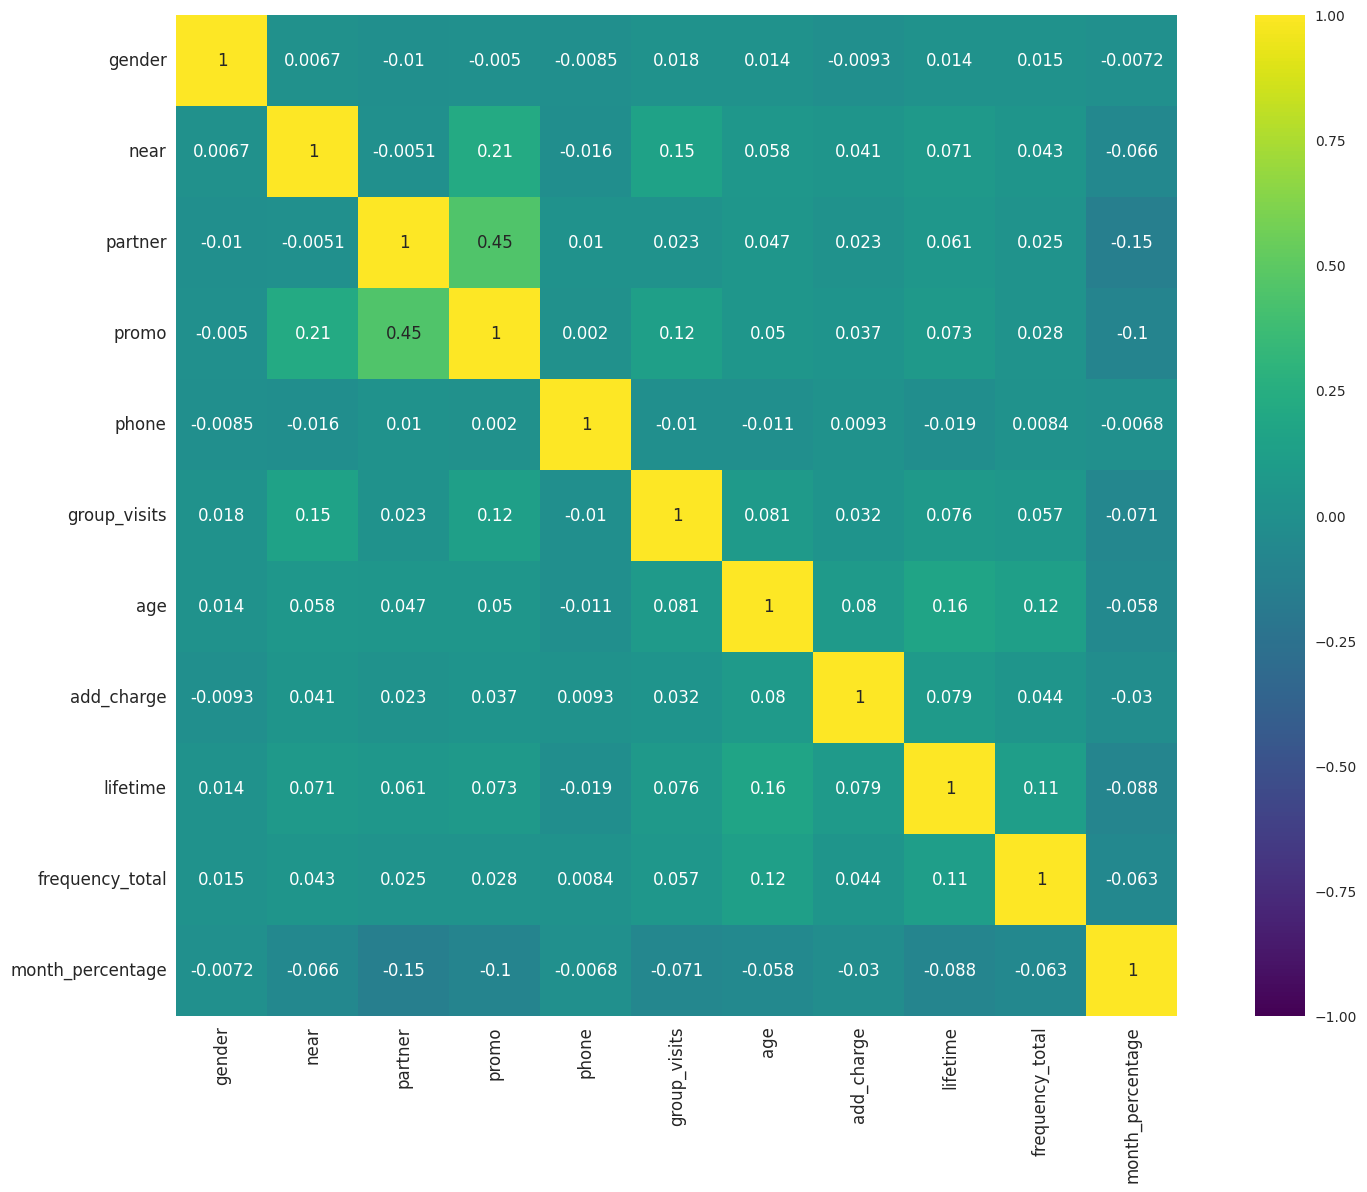

In [ ]:
corr_matrix = df.drop(columns=['churn']).corr()

plt.figure(figsize=(20,13))

sns.heatmap(corr_matrix, vmax=1, vmin=-1, square=True, annot=True, cmap='viridis')

plt.tick_params(labelsize=12);

### XGBoost: Use all variables to predict churn

#### Make a copy of dataframe for this part analysis

In [ ]:
df3 = df

#### Produce a train/test split for model comparison

In [ ]:
X = df3.drop(columns = ['churn'])

y = df3['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

##### Check that the training and testing input variables have similar means and standard deviations.

In [ ]:
X_train.agg(['mean','std']).round(2).T

,mean,std
gender,0.51,0.50
near,0.85,0.36
partner,0.49,0.50
promo,0.31,0.46
phone,0.90,0.30
group_visits,0.41,0.49
age,29.17,3.23
add_charge,147.14,96.38
lifetime,3.74,3.78
frequency_total,1.89,0.97


In [ ]:
X_test.agg(['mean','std']).round(2).T

,mean,std
gender,0.50,0.50
near,0.83,0.37
partner,0.48,0.50
promo,0.32,0.47
phone,0.93,0.25
group_visits,0.41,0.49
age,29.22,3.35
add_charge,146.17,96.33
lifetime,3.66,3.61
frequency_total,1.85,0.98


##### Check that the training and testing input variables have similar proportions of days where it rained today.

In [ ]:
y_train.value_counts(normalize=True)

0    0.73625
1    0.26375
Name: churn, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.72875
1    0.27125
Name: churn, dtype: float64

##### Perform the scaling transform on the predictors in the training and testing sets.

In [ ]:
numerical_columns = X_train.select_dtypes(include='number').columns.to_list()

In [ ]:
scaler = StandardScaler().fit(X_train[numerical_columns])

In [ ]:
X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

##### Check the mean and standard deviation of the transformed data.

In [ ]:
print(np.mean(X_train[numerical_columns], axis = 0).round(2))
print(np.std(X_train[numerical_columns], axis = 0))

print(np.mean(X_test[numerical_columns], axis = 0).round(2))
print(np.std(X_test[numerical_columns], axis = 0).round(2))

gender              0.0
near               -0.0
partner             0.0
promo              -0.0
phone              -0.0
group_visits        0.0
age                -0.0
add_charge         -0.0
lifetime           -0.0
frequency_total     0.0
month_percentage    0.0
dtype: float64
gender              1.0
near                1.0
partner             1.0
promo               1.0
phone               1.0
group_visits        1.0
age                 1.0
add_charge          1.0
lifetime            1.0
frequency_total     1.0
month_percentage    1.0
dtype: float64
gender             -0.03
near               -0.04
partner            -0.01
promo               0.02
phone               0.11
group_visits        0.00
age                 0.01
add_charge         -0.01
lifetime           -0.02
frequency_total    -0.04
month_percentage    0.05
dtype: float64
gender              1.00
near                1.04
partner             1.00
promo               1.01
phone               0.83
group_visits        1.00
ag

##### Create data frames that join the predictor variables and output variable for the training and testing data.

In [ ]:
df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

#### XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model,
                            param_distributions=params,
                            n_iter=200,
                            cv=5,
                            verbose=1,
                            n_jobs=-1,
                            return_train_score=True)

search.fit(X_train,
           y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d0e5f0e7130>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d0e62eee080>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d0e5f0e6050>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7d0e5f0e5e40>},
                   return_train_score=True, verbose=1)

In [ ]:
search.best_params_

{'colsample_bytree': 0.7343028466086052,
 'gamma': 0.11833189939005262,
 'learning_rate': 0.06824840572309149,
 'max_depth': 2,
 'n_estimators': 121,
 'subsample': 0.9966358655848988}

In [ ]:
xgb_model = xgb.XGBClassifier()
xgb_model.set_params(**search.best_params_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7343028466086052, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.11833189939005262,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06824840572309149,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=121, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_model.fit(X_train,
           y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7343028466086052, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.11833189939005262,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06824840572309149,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=121, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

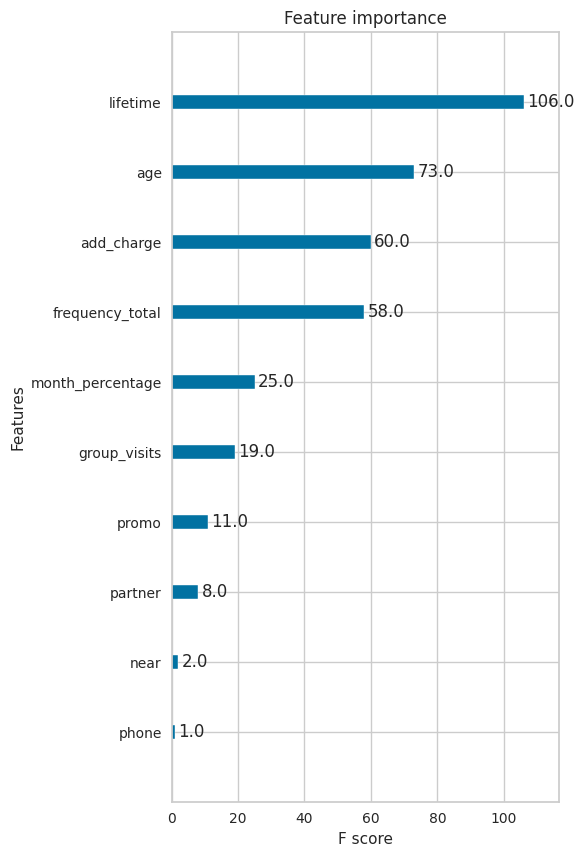

In [ ]:
fig, ax = plt.subplots(figsize = (5,10))
xgb.plot_importance(xgb_model, ax = ax);

In [ ]:
pred_mgb = xgb_model.predict(X_test)

In [ ]:
mat_mgb = confusion_matrix(y_test, pred_mgb)

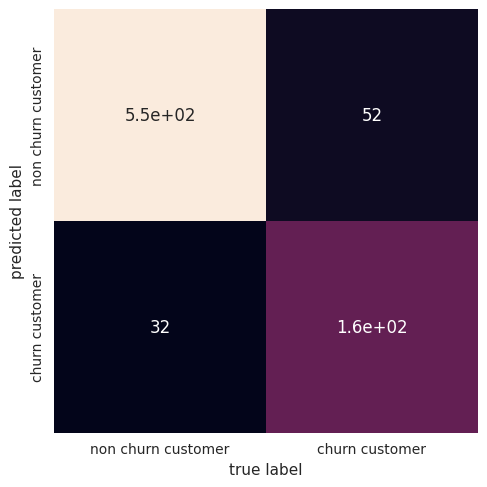

In [ ]:
class_names = ['non churn customer', 'churn customer']
sns.heatmap(mat_mgb.T, square=True, annot=True, cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
print(classification_report(y_test, pred_mgb, target_names=class_names))

                    precision    recall  f1-score   support

non churn customer       0.91      0.95      0.93       583
    churn customer       0.84      0.76      0.80       217

          accuracy                           0.90       800
         macro avg       0.88      0.85      0.86       800
      weighted avg       0.89      0.90      0.89       800



### Logistic regression(two variables)

In my opinion, I think month left in contract and average class frequency in total might help me to taste a flavor for this dataset

#### Create a copy for this test

In [ ]:
df1 = df

In [ ]:
df.head()

,gender,near,partner,promo,phone,group_visits,age,add_charge,lifetime,frequency_total,churn,month_percentage
0,1,1,1,1,0,1,29,14.23,3,0.02,0,0.83
1,0,1,0,0,1,1,31,113.20,7,1.92,0,1.00
2,0,1,1,0,1,0,28,129.45,2,1.86,0,1.00
3,0,1,1,1,1,1,33,62.67,2,3.21,0,1.00
4,1,1,1,1,1,0,26,198.36,3,1.11,0,1.00


#### Create train and test data

In [ ]:
X = df1.drop(columns='churn')

y = df1['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

numerical_columns = X_train.select_dtypes(include='number').columns.to_list()

scaler = StandardScaler().fit(X_train[numerical_columns])

X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

#### With two predictors, use `churn` as a color of the points to visualize the data.

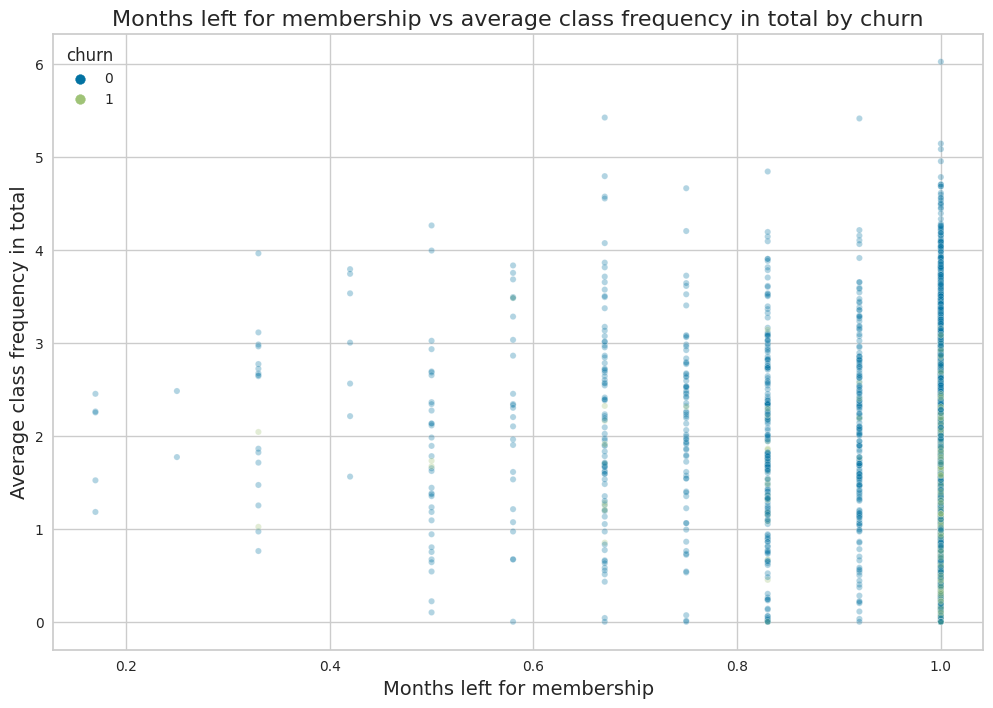

In [ ]:
plt.figure(figsize = (12,8))
sns.scatterplot(data=df1, x='month_percentage', y='frequency_total', hue='churn', alpha=0.3, s=20)

plt.xlabel('Months left for membership', fontsize=14)
plt.ylabel('Average class frequency in total', fontsize=14)
plt.title('Months left for membership vs average class frequency in total by churn', fontsize=16)
plt.show()

#### Fit the logistic regression model with predictors `month_percentage` and `frequency_total`, using the training data

In [ ]:
log_reg2 = sm.Logit(y_train, sm.add_constant(X_train[['month_percentage',  'frequency_total']])).fit()

Optimization terminated successfully.
         Current function value: 0.528813
         Iterations 7


In [ ]:
print(log_reg2.summary())

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 3200
Model:                          Logit   Df Residuals:                     3197
Method:                           MLE   Df Model:                            2
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                 0.08342
Time:                        07:42:25   Log-Likelihood:                -1692.2
converged:                       True   LL-Null:                       -1846.2
Covariance Type:            nonrobust   LLR p-value:                 1.296e-67
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2102      0.049    -24.874      0.000      -1.306      -1.115
month_percentage     0.6852      0.090      7.601      0.000       0.509       0.862
frequency_total     -0.6146 

#### Cross validation

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

cv = StratifiedKFold(n_splits=5)

# Perform cross-validation
cross_val_score(LogisticRegression(), X_train, y_train, cv=cv)

array([0.8828125, 0.8625   , 0.8765625, 0.8859375, 0.8875   ])

#### Evaluate the model accuracy

In [ ]:
pred2 = round(log_reg2.predict(sm.add_constant(X_test[['month_percentage', 'frequency_total']])))

In [ ]:
mat2 = confusion_matrix(y_test, pred2)

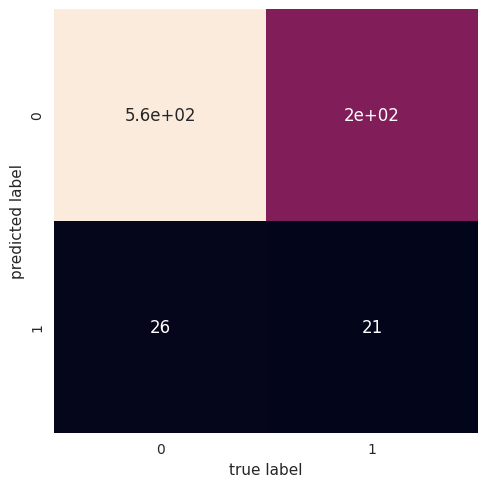

In [ ]:
sns.heatmap(mat2.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#### Accuracy score

In [ ]:
accuracy_score(y_test, pred2)

0.7225

### Logistic regression test with all predictors

In [ ]:
df2 = df

In [ ]:
X = df2.drop(columns='churn')

y = df2['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 1)

numerical_columns = X_train.select_dtypes(include='number').columns.to_list()

scaler = StandardScaler().fit(X_train[numerical_columns])

X_train[numerical_columns] = scaler.transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

df_train = X_train.join(y_train)
df_test = X_test.join(y_test)

In [ ]:
log_reg3 = sm.Logit(y_train, sm.add_constant(X_train)).fit()

Optimization terminated successfully.
         Current function value: 0.265223
         Iterations 9


In [ ]:
print(log_reg3.summary())

                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                 3200
Model:                          Logit   Df Residuals:                     3188
Method:                           MLE   Df Model:                           11
Date:                Mon, 04 Dec 2023   Pseudo R-squ.:                  0.5403
Time:                        07:37:25   Log-Likelihood:                -848.71
converged:                       True   LL-Null:                       -1846.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -3.3791      0.148    -22.762      0.000      -3.670      -3.088
gender               0.0258      0.061      0.421      0.674      -0.094       0.146
near                -0.1398 

Cross validation

In [ ]:
cv = StratifiedKFold(n_splits=5)

# Perform cross-validation
cross_val_score(LogisticRegression(), X_train, y_train, cv=cv)

array([0.8828125, 0.8625   , 0.8765625, 0.8859375, 0.8875   ])

In [ ]:
pred3 = round(log_reg3.predict(sm.add_constant(X_test)))

In [ ]:
mat3 = confusion_matrix(y_test, pred3)

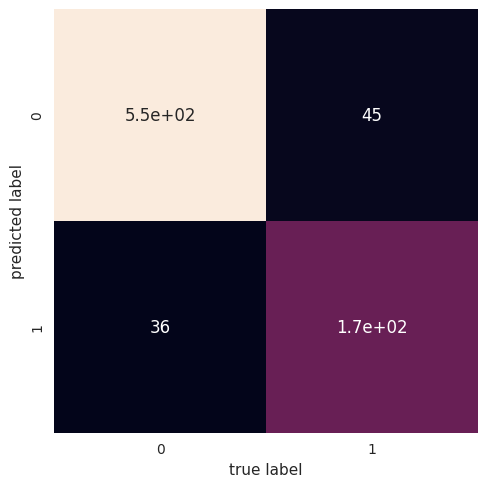

In [ ]:
sns.heatmap(mat3.T, square=True, annot=True, cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
accuracy_score(y_test, pred3)

0.89875

### K-means clustering

#### Prepare data

In [ ]:
df5 = df.drop(['gender', 'near', 'partner', 'promo', 'phone', 'group_visits', 'churn'], axis=1)

#### Choose number of clusters: Elbow method

Plotting the Elbow graph

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

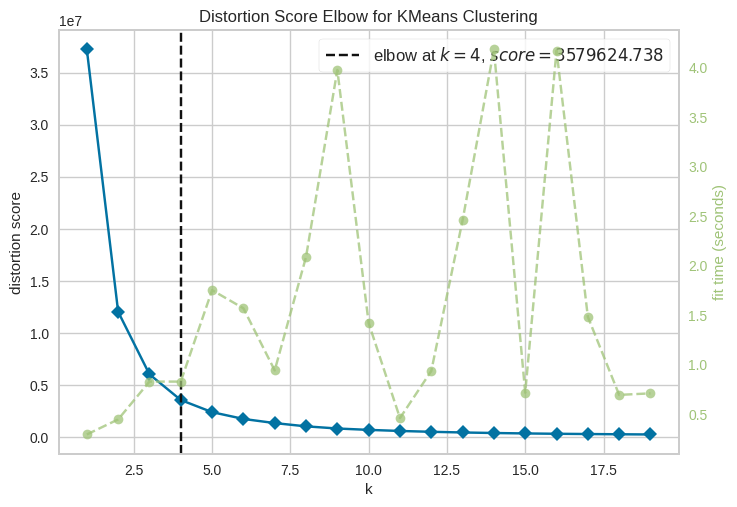

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(df5)
visualizer.show();

#### Predict clusters

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(df5)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Use Silhouette Score to check the accuracy

In [ ]:
from sklearn.metrics import silhouette_score
silhouette_score(df5, clusters)

0.5400485014761655

Add cluster information to the dataframe

In [ ]:
df['Cluster'] = clusters

#### Get churn rate for each clusters

In [ ]:
df.groupby('Cluster')['churn'].mean()

Cluster
0    0.196753
1    0.346656
2    0.301815
3    0.076543
Name: churn, dtype: float64

1 and 2 has the highest churn rate. In this case, I'm interested in the characteristics of these two groups.

In [ ]:
df5.describe()


,age,add_charge,lifetime,frequency_total,month_percentage
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,29.184250,146.943730,3.724750,1.879035,0.963485
std,3.258367,96.355654,3.749267,0.972305,0.104835
min,18.000000,0.150000,0.000000,0.000000,0.170000
25%,27.000000,68.865000,1.000000,1.180000,1.000000
50%,29.000000,136.220000,3.000000,1.830000,1.000000
75%,31.000000,210.947500,5.000000,2.540000,1.000000
max,41.000000,552.590000,31.000000,6.020000,1.000000


#### Draw a plot of clusters

Reduce dimension using PCA

In [ ]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(df5)

Create a DataFrame with PCA results and cluster labels

In [ ]:
plot_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
plot_df['cluster'] = clusters

Create an Interactive Plot with Plotly

In [ ]:
fig = px.scatter(plot_df, x='PC1', y='PC2',
                 color='cluster',  # define the color of points
                 hover_data=['cluster'],  # what info to show when hovering over a point
                 title='Cluster Plot')

# Show the plot
fig.show()